# Simulate a solargraph

I'll try to simulate a solargraph (made with a [SolarCan](https://solarcan.co.uk) or a [hand-made](http://xyzon.nl/solargraphschoolproject/) tin pinhole camera).

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy.coordinates import AltAz, EarthLocation, get_sun
from astropy.time import Time
import astropy.units as u
import numpy as np

The position of the Sun depends on the coordinates of the camera. The site can be specified either by address or by its coordinates.

In [2]:
site = EarthLocation.of_address("Dwingeloo")
site = EarthLocation(lat=52.81242922*u.deg, lon=6.39620204*u.deg, height=17*u.m)

In [3]:
startdate = Time("2020-07-28T12:00")

In [4]:
enddate = Time("2020-12-21T12:00")

Now some coordinates. To get the image coordinates $x$, $y$ from the azimuth $\gamma$ and altitude $\alpha$, let's first choose convenient scalings. Let $x$ run from $-180^\circ$ to $+180^\circ$ (we can later scale with a scaling factor in degrees per cm or so). The paper is rolled up in the can, so $x=0$ will be directly opposite the pin hole. Choose the origin of the azimuth $\gamma$ to be straight out of the pinhole, as illustrated below.

<img src="diagram.png">

Now we have $x = 2\gamma$, so that when $\gamma$ runs from $-90^\circ$ to $+90^\circ$, $x$ spans the whole paper.

To get the $y$ coordinate, we can use the horizontal distance to the tin can $f_h$. This is the [chord](https://en.wikipedia.org/wiki/Chord_(geometry)) of $180^\circ-x$, which is
$
f_h=2\sin((180^\circ-x)/2)=2\cos(x/2)
$.

The $y$ coordinate now is $f_h \cdot \tan(\alpha)$ (where $\alpha$ is the incoming altitude).

In [5]:
num_days = round((enddate - startdate).to(u.day).value)
day_step = 5 # A trail will be plotted every so many days

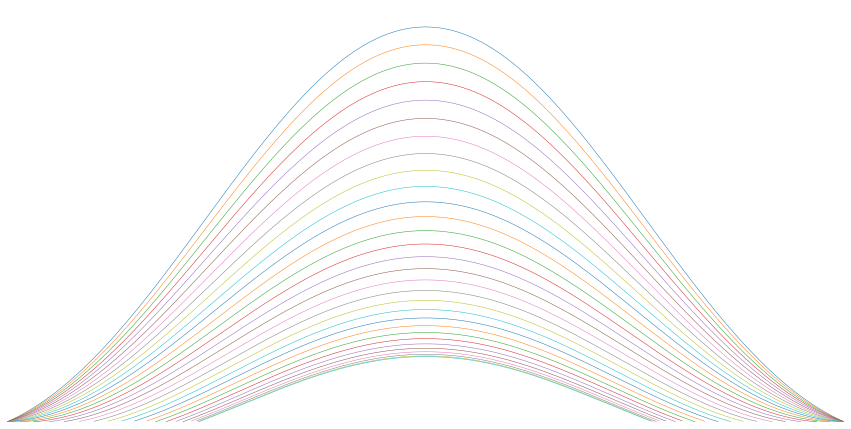

In [6]:
basetimes = startdate - 9 * u.hour + np.linspace(0, 18, 341) * u.hour

fig, ax = plt.subplots(figsize=(15, 15))

for nr, offset in enumerate(np.arange(0, num_days, day_step) * u.day):
    times = basetimes + offset

    aa = get_sun(times).transform_to(AltAz(location=site, obstime=times))
    gamma = aa.az
    alpha = aa.alt
    x = 2 * (gamma - 180 * u.deg)
    y = np.rad2deg((2 * np.cos(x / 2) * np.tan(alpha)).value)
    y[aa.alt < 0] = np.nan

    if np.min(np.abs(times - Time("2020-10-05T12:00"))) < 1 * u.hour:
        ax.plot(x, y, color='black', lw=1.5)
    else:
        ax.plot(x, y, lw=0.5)

ax.set_xlim(-180, 180)
ax.set_ylim(0, None)
ax.set_axis_off()
ax.set_aspect(1)
fig.savefig("solargraph-theoretic.png", bbox_inches="tight", dpi=200)

# Add telescope

In [7]:
from pyproj import Transformer

In [8]:
rds_to_wgs84 = Transformer.from_crs(28992, 4326)

In [9]:
xyz = np.loadtxt("/Users/dijkema/camras/ahn3-puntenwolk/ahn3-matplotlib/dt-full.txt", skiprows=1)[:, :3]

In [10]:
!wget https://github.com/tammojan/ahn3-matplotlib/raw/master/dt-cloud.txt

/bin/sh: wget: command not found


In [11]:
dt_lat, dt_lon, dt_height = rds_to_wgs84.transform(*xyz.T)

In [12]:
dt_points = EarthLocation(lon=dt_lon * u.deg, lat=dt_lat*u.deg, height=dt_height*u.m)

In [13]:
dt_altaz = dt_points.get_itrs().transform_to(AltAz(location=site))

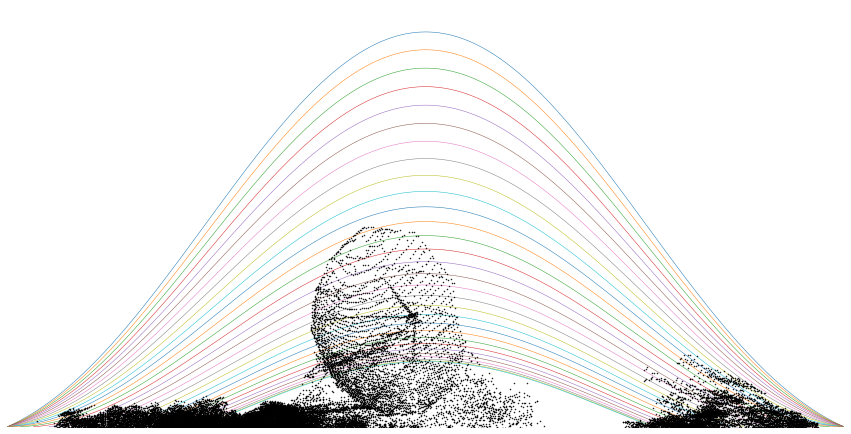

In [14]:
basetimes = startdate - 9 * u.hour + np.linspace(0, 18, 341) * u.hour

fig, ax = plt.subplots(figsize=(15, 15))

for nr, offset in enumerate(np.arange(0, num_days, day_step) * u.day):
    times = basetimes + offset

    sun_altaz = get_sun(times).transform_to(AltAz(location=site, obstime=times))
    gamma = sun_altaz.az
    alpha = sun_altaz.alt
    x = 2 * (gamma - 180 * u.deg)
    y = np.rad2deg((2 * np.cos(x / 2) * np.tan(alpha)).value)
    y[sun_altaz.alt < 0] = np.nan

    if np.min(np.abs(times - Time("2020-10-05T12:00"))) < 1 * u.hour:
        ax.plot(x, y, color='black', lw=1.5)
    else:
        ax.plot(x, y, lw=0.5)

gamma = dt_altaz.az
alpha = dt_altaz.alt
x = 2 * (gamma - 180 * u.deg)
y = np.rad2deg((2 * np.cos(x / 2) * np.tan(alpha)).value)
y[dt_altaz.distance < 10*u.m] = np.nan

ax.plot(x, y, '.', markersize=1, color='black')
ax.set_xlim(-180, 180)
ax.set_ylim(0, None)
ax.set_axis_off()
ax.set_aspect(1)
fig.savefig("solargraph-theoretic.png", bbox_inches="tight", dpi=200, facecolor='white')